In [1]:
import sys 
sys.path.append('../../../')
from src.import_packages import *
from src.visualize_EDA import vEDA

# sys.path.append('..')
# from data.custom_metric_JVowOkK import *

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, f1_score, make_scorer, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from lightgbm import LGBMClassifier, plot_importance

# from keras.models import Sequential
# from keras.layers import Dense, Activation, Dropout
# from tensorflow.keras.optimizers import SGD, Adam
# from keras.regularizers import l1, l2
# from keras.utils.vis_utils import plot_model
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from livelossplot import PlotLossesKeras
# from keras.utils import np_utils


from tqdm import tqdm

def predict_DL(DL_model, data, labelencoder):

    probs_ = DL_model.predict(data) 
    classes_ = np.argmax(probs_, axis=1)
    classes_tranformed_ = labelencoder.inverse_transform(classes_)

    return classes_tranformed_

def clustering_metrics(data, K = range(2, 20 + 1)):
    
    Sum_of_squared_distances = []
    Silhouette_value = []
    Calinski_Harabasz = []
    Davies_Bouldin = []

    for k in K:

        km = KMeans(n_clusters = k, n_init = 20, max_iter = 500, random_state = 20202020)
        km = km.fit(data)
        labels = km.labels_

        Sum_of_squared_distances.append(km.inertia_)
        Silhouette_value.append(silhouette_score(data, labels, metric = 'euclidean'))
        Calinski_Harabasz.append(calinski_harabasz_score(data, labels))
        Davies_Bouldin.append(davies_bouldin_score(data, labels))

    fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 7))

    sns.pointplot(x = list(K), y = Sum_of_squared_distances, markers = 'x', s = 10, ax = ax[0, 0])
    sns.pointplot(x = list(K), y = Silhouette_value, markers = 'x', s = 10, ax = ax[1, 0])
    sns.pointplot(x = list(K), y = Calinski_Harabasz, markers = 'x', s = 10, ax = ax[0, 1])
    sns.pointplot(x = list(K), y = Davies_Bouldin, markers = 'x', s = 10, ax = ax[1, 1])

    ax[0, 0].title.set_text('Sum of squared distances ("elbow")')
    ax[1, 0].title.set_text('Silhouette value')
    ax[0, 1].title.set_text('Calinski-Harabasz')
    ax[1, 1].title.set_text('Davies-Bouldin')

    plt.show()


def return_scaled_dataframe(df, scaler = StandardScaler()):    

    df_scaled = df.copy()
    df_scaled = scaler.fit_transform(df_scaled)
    df_scaled = pd.DataFrame(df_scaled, columns = df.columns)

    return df_scaled


def plot_clusters_with_PCA(data, K):
    
    pca = PCA(random_state = 20202020).fit(data)

    pca_plot = pd.DataFrame(pca.transform(data))[[0, 1]]
    pca_plot.columns = ['PCA_1', 'PCA_2']
    pca_plot.index = data.index
    pca_plot.reset_index(inplace = True)

    km = KMeans(n_clusters = K, n_init = 20, max_iter = 500, random_state = 20202020).fit(data)
    km = pd.DataFrame(km.predict(data), columns = ['clusters'])

    kmeans_results = pd.concat([pca_plot, km], 1)
    kmeans_results.clusters = kmeans_results.clusters.astype('object')

    fig, ax = plt.subplots(figsize = (12, 6))
    sns.scatterplot(x = 'PCA_1', y = 'PCA_2', data = kmeans_results, s = 50, hue = 'clusters', 
                    palette = sns.color_palette("Set1", kmeans_results.clusters.nunique()))
    ax.title.set_text(str(K) + ' clusters')
    ax.legend(fontsize = 'small')
    plt.show()

    return kmeans_results

Importing the following packages: pandas, numpy, matplotlib, seaborn, plotly, warnings


### Meta info

In [2]:
info_static = pd.read_csv('../data/info_static.csv')
info_static.head(3)

,t_id,s_id,latitude,longitude,street,city,zipcode,model
0,S84-T1,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"E/F, Combo, T2, CHAdeMO, T3"
1,S84-T3,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"CHAdeMO, T2, T3, E/F, Combo"
2,S86-T1,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,"CHAdeMO, Combo, T2, T3, E/F"


### X and y files

In [3]:
X = pd.read_csv('../data/xtrain.csv')
X_test = pd.read_csv('../data/xtest.csv')
y = pd.read_csv('../data/ytrain_NpxebDC.csv')

submission = pd.read_csv('../data/yrandom.csv')

How a submission file should look like

In [4]:
submission.head(3)

,timestamp,S7-T1,S2-T1,S19-T1,S56-T3,S85-T3,S16-T3,S16-T1,S94-T3,S28-T1,...,S47-T2,S65-T2,S32-T2,S21-T2,S13-T2,S97-T2,S25-T1,S25-T2,S98-T2,S99-T2
0,2020-11-09T00:00:00+00:00,Offline,Available,Charging,Charging,Available,Available,Passive,Available,Charging,...,Down,Down,Available,Passive,Offline,Charging,Passive,Offline,Charging,Offline
1,2020-11-09T00:15:00+00:00,Passive,Down,Passive,Down,Charging,Passive,Down,Charging,Offline,...,Down,Down,Available,Available,Passive,Passive,Offline,Down,Down,Passive
2,2020-11-09T00:30:00+00:00,Passive,Passive,Charging,Available,Passive,Down,Available,Down,Available,...,Offline,Available,Down,Offline,Down,Charging,Available,Passive,Charging,Passive


X and y

In [5]:
X.head(3)

,timestamp,temperature,wind_speed,wind_gust_speed,rain_level,traffic_state,average_flow
0,2019-11-25T00:00:00+00:00,8.7,11.0,24.0,0.0,Fluid,218.1
1,2019-11-25T01:00:00+00:00,8.8,9.0,20.0,0.0,Fluid,144.3
2,2019-11-25T02:00:00+00:00,8.9,8.0,18.0,0.0,Fluid,110.0


In [6]:
y.head(3)

,timestamp,S7-T1,S2-T1,S19-T1,S56-T3,S85-T3,S16-T3,S16-T1,S94-T3,S28-T1,...,S47-T2,S65-T2,S32-T2,S21-T2,S13-T2,S97-T2,S25-T1,S25-T2,S98-T2,S99-T2
0,2019-11-25T00:00:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,...,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN
1,2019-11-25T00:15:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,...,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN
2,2019-11-25T00:30:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,...,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN


X feature engineering

In [7]:
X['timestamp'] = pd.to_datetime(X['timestamp'])

X['year'] = X['timestamp'].dt.year
X['month'] = X['timestamp'].dt.month
X['day'] = pd.to_datetime(X['timestamp']).dt.day_name()
X['hour'] = X['timestamp'].dt.hour

In [8]:
X['traffic_state'].value_counts()

Fluid    8015
Busy      325
Heavy       1
Name: traffic_state, dtype: int64

In [9]:
X['traffic_state'] = X['traffic_state'].replace({'Heavy' : 'Busy'})
X = pd.get_dummies(X, columns = ['traffic_state'], prefix_sep = ' = ').drop('traffic_state = Busy', 1)

X EDA

In [10]:
X_eda = vEDA(X)

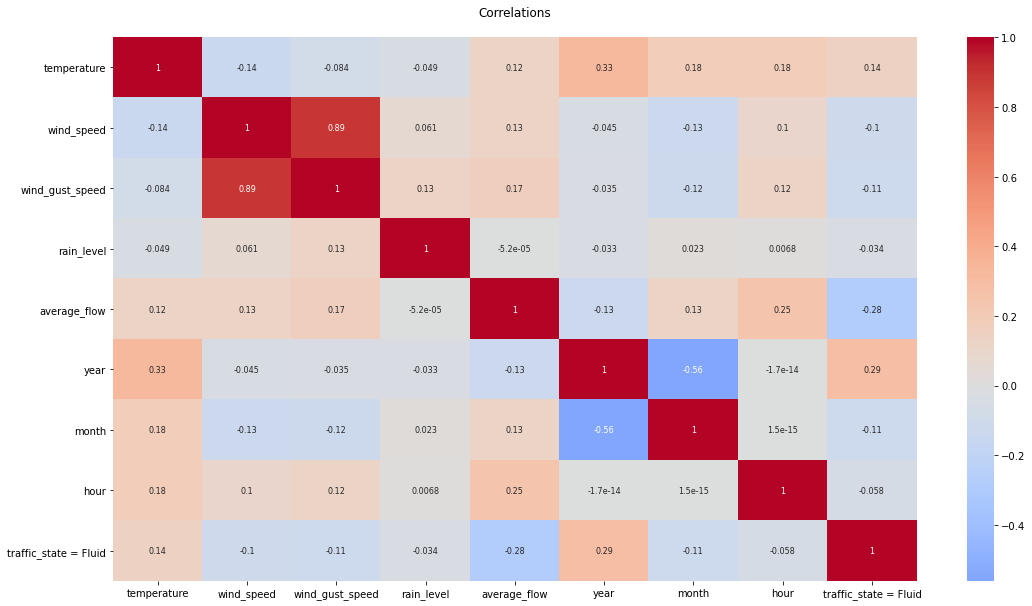

In [11]:
X_eda.plot_corr()

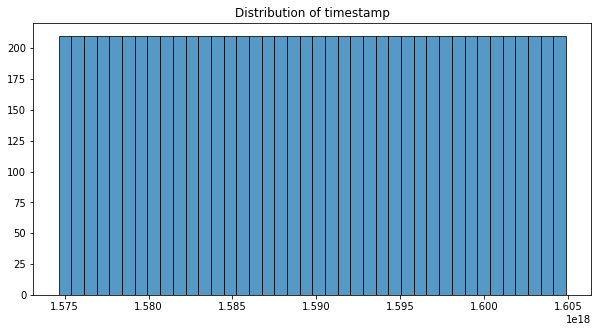

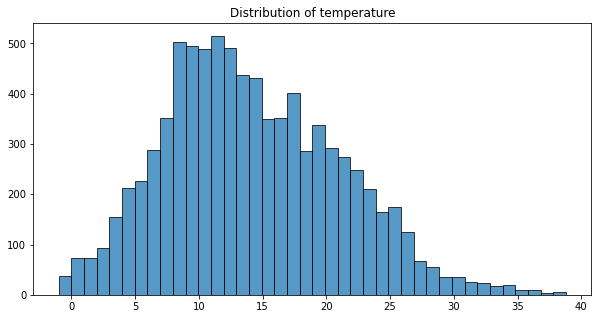

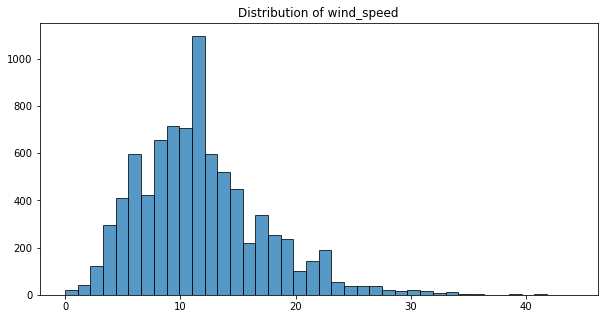

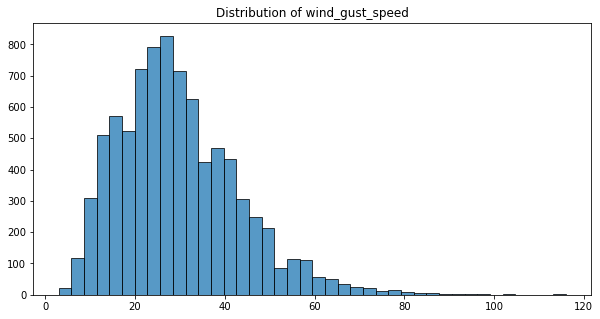

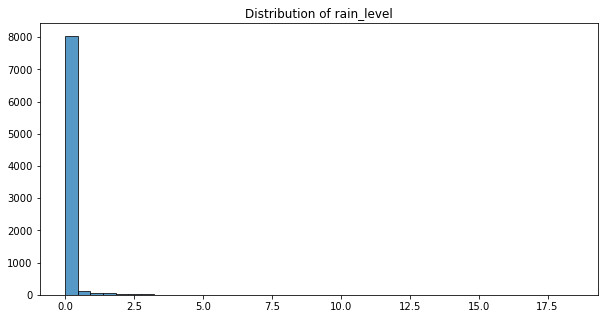

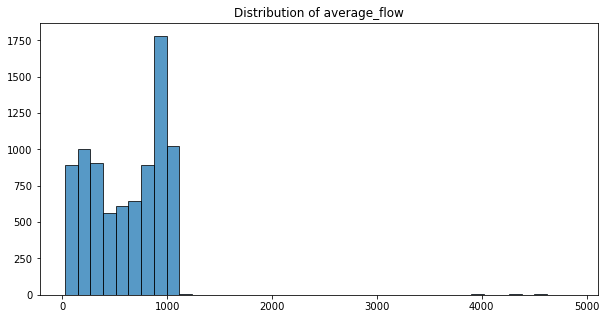

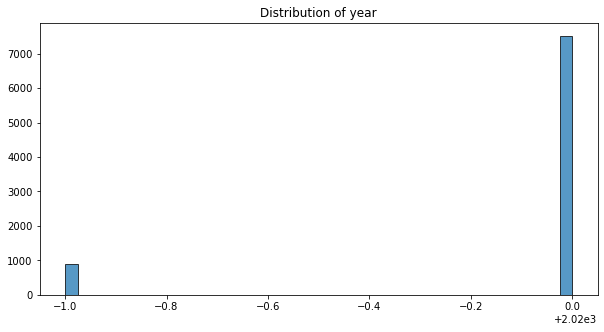

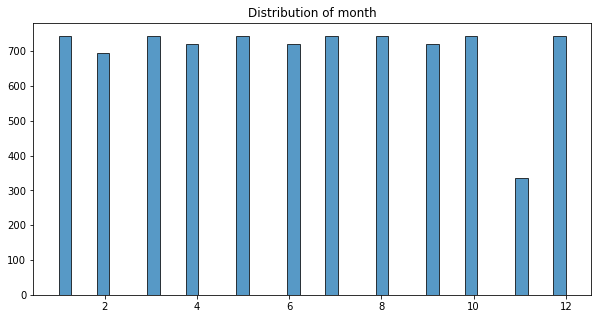

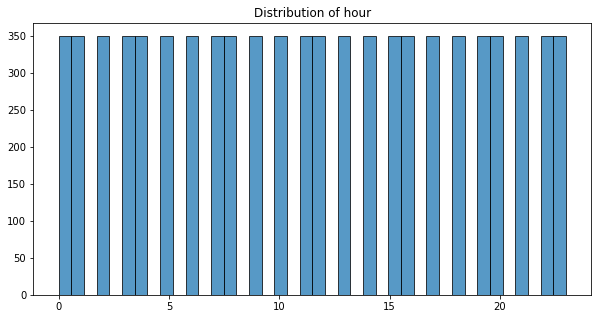

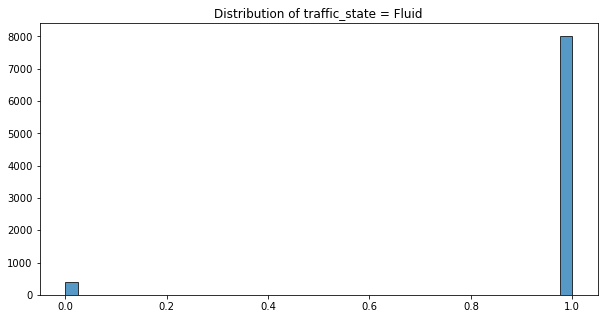

In [12]:
for i in X.select_dtypes(exclude = 'O').columns:
    X_eda.plot_dist(i)

### Capture difference across stations: use geo location

In [13]:
info_static.head(3)

,t_id,s_id,latitude,longitude,street,city,zipcode,model
0,S84-T1,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"E/F, Combo, T2, CHAdeMO, T3"
1,S84-T3,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"CHAdeMO, T2, T3, E/F, Combo"
2,S86-T1,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,"CHAdeMO, Combo, T2, T3, E/F"


In [14]:
vEDA(info_static).plot_geo_map('latitude', 'longitude', zoom = 11)

In [15]:
set(', '.join(info_static['model'].to_list()).split(', '))

{'CHAdeMO', 'Combo', 'E/F', 'T2', 'T3'}

Capture station types in OHE features

In [16]:
for i in ['CHAdeMO', 'Combo', 'E/F', 'T2', 'T3']:
    col_name = 'model = ' + i
    info_static[col_name] = 0
    info_static.loc[info_static['model'].str.contains(i), col_name] = 1

In [17]:
info_static.drop('model', 1, inplace = True)

In [18]:
info_static.filter(like = 'model').value_counts()

model = CHAdeMO  model = Combo  model = E/F  model = T2  model = T3
1                1              1            1           1             182
0                0              1            0           0              91
dtype: int64

In [19]:
info_static['model = only E/F'] = 0
info_static.loc[(info_static['model = E/F'] == 1) & (info_static['model = Combo'] == 0), 'model = only E/F'] = 1

info_static['model = all'] = 0
info_static.loc[(info_static['model = E/F'] == 1) & (info_static['model = Combo'] == 1), 'model = all'] = 1

In [20]:
info_static.drop(info_static.filter(like = 'model').columns[:-2], 1, inplace = True)

In [21]:
vEDA(info_static).plot_geo_map('latitude', 'longitude', zoom = 11, color_by='model = all', hover_name='s_id')

Calculate 'neighbor information'

- how many stations are there in a 
    - ~500m (0.05 DD)
    - 1.11km (0.01 DD)
    - 2.22km (0.02 DD)


In [22]:
station_info = info_static[['s_id', 'latitude', 'longitude']].drop_duplicates('s_id').copy()
print(station_info.shape)
station_info.set_index('s_id', inplace = True)
station_info.head(3)

(91, 3)


,latitude,longitude
s_id,,
S84,48.863766,2.411770
S86,48.890610,2.354230
S68,48.875465,2.360103


In [23]:
tree = KDTree(station_info, leaf_size = 2)

In [24]:
n05km = [i-1 for i in tree.query_radius(station_info, r = 0.005, count_only = True)]
n1km = [i-1 for i in tree.query_radius(station_info, r = 0.01, count_only = True)]
n2km = [i-1 for i in tree.query_radius(station_info, r = 0.02, count_only = True)]

station_info['neighbors_500_m'] = n05km
station_info['neighbors_1_km'] = n1km
station_info['neighbors_2_km'] = n2km

In [25]:
info_static = info_static.merge(station_info.reset_index().drop(['latitude', 'longitude'], 1), on = 's_id')

### SKIP: Try clustering terminals (y data) by finding similarly behaving ones and treating them the same

1 prediction for a cluster = all predictions for terminals in the given cluster

In [26]:
# mapper = {'Available' : 1, 'Charging' : 2, 'Passive' : 3, 'Offline' : 4, 'Down' : 5}
# y_T_cluster = y.fillna('Offline').set_index('timestamp').T.replace(mapper)

# #all(y_T_cluster.dtypes == 'int64')

# clustering_metrics(y_T_cluster, K = range(110, 120 + 1))

# y_clusters = plot_clusters_with_PCA(y_T_cluster, 2)

Optimal cluster number seems to be:
- 2: 0.5
- 45: 0.3
- 47: 0.31
- 63, 66, 68, 69: 0.32
- 83: 0.33
- 106: 0.325

### Explore y a little more

In [27]:
y_count_targets = y.fillna('Offline').drop('timestamp', 1).apply(pd.Series.value_counts).fillna(0).astype(int).T
y_count_targets = y_count_targets.apply(lambda x: x / x.sum(), axis = 1)

In [28]:
y_count_targets.head(3)

,Available,Charging,Down,Offline,Passive
S7-T1,0.000000,0.000000,0.960713,0.039287,0.000000
S2-T1,0.549308,0.009029,0.016778,0.418737,0.006148
S19-T1,0.960713,0.000000,0.000000,0.039287,0.000000


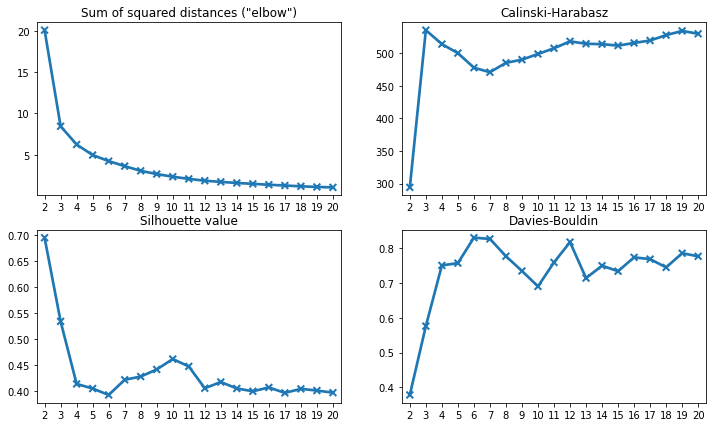

In [29]:
clustering_metrics(y_count_targets)

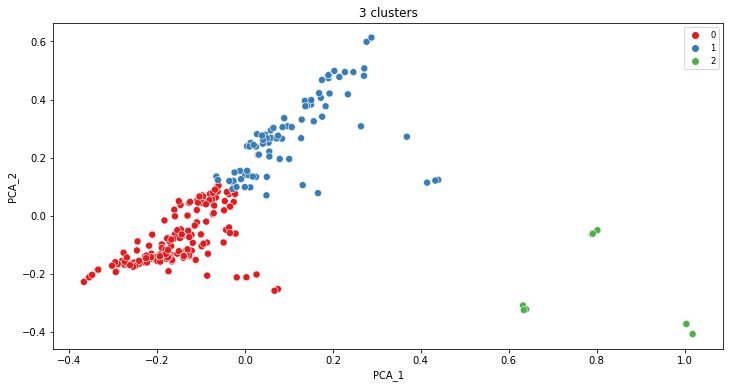

In [30]:
y_clusters = plot_clusters_with_PCA(y_count_targets, 3)

In [31]:
y_count_targets[y_count_targets.index.isin(y_clusters[y_clusters['clusters'] == 2]['index'].tolist())].mean()

Available    0.046105
Charging     0.000672
Down         0.884323
Offline      0.068367
Passive      0.000532
dtype: float64

## Second modeling approach: build as many models as there are terminals

Expand X with y data

In [32]:
Y = y.fillna('Offline')
Y['timestamp'] = pd.to_datetime(Y['timestamp'])
Y['minute'] = Y['timestamp'].dt.minute

In [33]:
X_y = X.merge(Y, on = 'timestamp', how = 'right').fillna(method='ffill')
print(X_y.shape)

(31232, 285)


In [34]:
TARGET_COLUMNS = Y.columns[1:-1].tolist()

In [41]:
X_y.drop(['timestamp'], 1, inplace = True)

In [42]:
X_y.head(3)

,temperature,wind_speed,wind_gust_speed,rain_level,average_flow,year,month,day,hour,traffic_state = Fluid,...,S65-T2,S32-T2,S21-T2,S13-T2,S97-T2,S25-T1,S25-T2,S98-T2,S99-T2,minute
0,8.7,11.0,24.0,0.0,218.1,2019.0,11.0,Monday,0.0,1.0,...,Offline,Offline,Available,Available,Offline,Offline,Offline,Offline,Offline,0
1,8.7,11.0,24.0,0.0,218.1,2019.0,11.0,Monday,0.0,1.0,...,Offline,Offline,Available,Available,Offline,Offline,Offline,Offline,Offline,15
2,8.7,11.0,24.0,0.0,218.1,2019.0,11.0,Monday,0.0,1.0,...,Offline,Offline,Available,Available,Offline,Offline,Offline,Offline,Offline,30


## Apply ML models

In [43]:
f1 = make_scorer(f1_score, average = 'weighted')

In [119]:
models = {}
accuracies = {}
reports = {}

# LGB_params = {'boosting_type' : ['gbdt', 'goss'],
#               'learning_rate' : [0.1],
#               'num_leaves' : [25],
#               'min_child_samples' : [5, 20],
#               'max_depth' : [17, 9],
#               'colsample_bytree' : [3/4],
#               'n_estimators' : [100, 150]}

# counter = 0
# all_iters = len(TARGET_COLUMNS)

for TERMINAL in tqdm(TARGET_COLUMNS, desc = 'LightGBM trained for all terminals'):

    _X_y = X_y.copy()

    # add aggregated features
    # ratio of targets by hour-min
    # ratio of targets by day-hour

    # HM = _X_y.groupby(['hour', 'minute', TERMINAL])['hour'].count() / _X_y.groupby(['hour', 'minute'])['hour'].count()
    # HM.name = ''
    # HM = HM.reset_index().pivot_table(index = ['hour', 'minute'], columns = TERMINAL, values = '').reset_index().fillna(0)
    # HM.columns = ['hour', 'minute'] + ['HM ratio of ' + i for i in HM.columns[2:]]
    # _X_y = _X_y.merge(HM, on = ['hour', 'minute'])


    # DH = _X_y.groupby(['day', 'hour', TERMINAL])['hour'].count() / _X_y.groupby(['day', 'hour'])['hour'].count()
    # DH.name = ''
    # DH = DH.reset_index().pivot_table(index = ['day', 'hour'], columns = TERMINAL, values = '').reset_index().fillna(0)
    # DH.columns = ['day', 'hour'] + ['DH ratio of ' + i for i in HM.columns[2:]]
    # _X_y = _X_y.merge(DH, on = ['day', 'hour'])


    # check very unfrequent targets  
    unfreq_target = _X_y[TERMINAL].value_counts()[_X_y[TERMINAL].value_counts() <= 20].index

    if unfreq_target.size > 0:
        _y = _X_y.loc[~_X_y[TERMINAL].isin(unfreq_target.tolist())][TERMINAL]
        _X = _X_y.loc[~_X_y[TERMINAL].isin(unfreq_target.tolist())].drop(TARGET_COLUMNS, 1)
    else:
        _y = _X_y[TERMINAL]
        _X = _X_y.drop(TARGET_COLUMNS, 1)    
    
    _X = pd.get_dummies(_X, columns = ['day']).drop('day_Monday', 1)

    _Xtr, _Xv, _ytr, _yv = train_test_split(_X, _y, train_size = .7, random_state = 975)

    if _y.nunique() <= 2:
        
        LGB = LGBMClassifier(random_state = 975, objective = 'binary', n_jobs = -1, colsample_bytree = 3/4)
        LGB.fit(_Xtr, _ytr, eval_set = (_Xv, _yv), verbose = 0, early_stopping_rounds = 20)        
        
        #GRID_LGB = GridSearchCV(LGB, param_grid = LGB_params, cv = 3, scoring = f1, n_jobs = -1)
        #GRID_LGB.fit(_Xtr, _ytr)

    else:

        LGB = LGBMClassifier(random_state = 975, objective = 'multiclass', n_jobs = -1, colsample_bytree = 3/4) 
        LGB.fit(_Xtr, _ytr, eval_set = (_Xv, _yv), verbose = 0, early_stopping_rounds = 20)  

        # GRID_LGB = GridSearchCV(LGB, param_grid = LGB_params, cv = 3, scoring = f1, n_jobs = -1)
        # GRID_LGB.fit(_Xtr, _ytr)

    _predictions = LGB.predict(_Xv) # GRID_LGB.best_estimator_
    _accuracy = accuracy_score(_yv, _predictions)
    _class_report = classification_report(_yv, _predictions, digits = 4)

    models[TERMINAL] = LGB # GRID_LGB.best_estimator_
    accuracies[TERMINAL] = _accuracy
    reports[TERMINAL] = _class_report



LightGBM trained for all terminals: 100%|██████████| 273/273 [19:28<00:00,  4.28s/it]


In [73]:
import pickle

# pkl_filename = '../data/accuracies.pkl'
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(accuracies, file)

# pkl_filename = '../data/reports.pkl'
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(reports, file)

# tuned_parameters = {}

# for i in models:
#     tuned_parameters[i] = models[i].get_params()

# pkl_filename = '../data/tuned_parameters.pkl'
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(tuned_parameters, file)

In [120]:
ACC_RESULTS = pd.DataFrame.from_dict(accuracies, orient = 'index', columns = ['accuracy']).reset_index()

<AxesSubplot:>

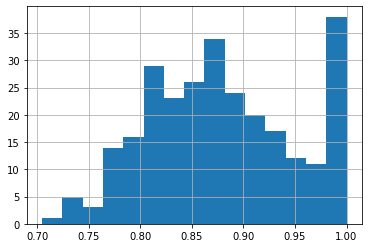

In [121]:
ACC_RESULTS['accuracy'].hist(bins = 15)

In [122]:
ACC_RESULTS['accuracy'].describe(percentiles = [.1, .25, .5, .75, .9])

count    273.000000
mean       0.879071
std        0.072596
min        0.704803
10%        0.787837
25%        0.823052
50%        0.873426
75%        0.932109
90%        0.999680
max        1.000000
Name: accuracy, dtype: float64

### Create submission file

#### Run X_test thru processing steps

In [126]:
def process_X(data, submission_example):

    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['year'] = data['timestamp'].dt.year
    data['month'] = data['timestamp'].dt.month
    data['day'] = pd.to_datetime(data['timestamp']).dt.day_name()
    data['hour'] = data['timestamp'].dt.hour

    data['traffic_state'] = data['traffic_state'].replace({'Heavy' : 'Busy'})
    data = pd.get_dummies(data, columns = ['traffic_state'], prefix_sep = ' = ')#.drop('traffic_state = Busy', 1)

    # X test has some NaNs in weather-like features
    # impute by taking rolling mean (need 81 as there are ranges of NaNs with 81)
    data = data.fillna(data.rolling(81, min_periods = 1).mean())

    # expand Y (minutes)

    submission_example = submission_example.fillna('Offline')
    submission_example['timestamp'] = pd.to_datetime(submission_example['timestamp'])
    submission_example['minute'] = submission_example['timestamp'].dt.minute
  
    data = data.merge(submission_example, on = 'timestamp', how = 'right').fillna(method='ffill')
    data.drop('timestamp', 1, inplace = True)
    data = pd.get_dummies(data, columns = ['day']).drop('day_Monday', 1)
    data.drop(TARGET_COLUMNS, 1, inplace = True)

    return data

In [127]:
X_test_processed = process_X(X_test, submission)

#### Predict on test set

In [128]:
test_predictions = pd.DataFrame()
test_predictions['timestamp'] = submission.timestamp

In [86]:
for i in submission.columns[1:]:
    test_predictions[i] = models[i].predict(X_test_processed)

In [91]:
test_predictions.to_csv('../data/SUBMISSION_SEPARATE_MODELS_TUNED.csv', index = False)